In [2]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import json

nltk.download('stopwords')
nltk.download('punkt')

np.random.seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Load dataset
df1 = pd.read_csv(r"C:\Users\HP\Desktop\ML PROJECT\Combined Data.csv")
print("Dataset shape:", df1.shape)
print("Columns:", df1.columns.tolist())

# Find text and label columns
text_col = None
label_col = None

for col in df1.columns:
    if 'text' in col.lower() or 'content' in col.lower() or 'statement' in col.lower():
        text_col = col
    if 'label' in col.lower() or 'sentiment' in col.lower() or 'status' in col.lower():
        label_col = col

# If not found, just use first and last column
if text_col is None:
    text_col = df1.columns[1]  # usually second column
if label_col is None:
    label_col = df1.columns[-1]

print("Using text column:", text_col)
print("Using label column:", label_col)

# Rename columns
df1 = df1.rename(columns={text_col: 'content', label_col: 'sentiment'})
df1 = df1[['content', 'sentiment']].copy()

# Remove missing values
df1 = df1.dropna()
print("\nAfter removing nulls:", df1.shape[0])
print("Sentiment counts:")
print(df1['sentiment'].value_counts())

Dataset shape: (53043, 3)
Columns: ['Unnamed: 0', 'statement', 'status']
Using text column: statement
Using label column: status

After removing nulls: 52681
Sentiment counts:
sentiment
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64


In [4]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', str(text))
    text = re.sub(r'www\.\S+', '', text)
    
    # Remove @ mentions and hashtags
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Lowercase
    text = text.lower()
    
    # Remove stopwords and short words
    words = text.split()
    words = [w for w in words if w not in stop_words and len(w) > 2]
    
    return ' '.join(words)

# Clean the text
print("Cleaning text...")
df1['cleaned_content'] = df1['content'].apply(clean_text)

# Remove empty rows
df1 = df1[df1['cleaned_content'].str.len() > 0]
print("After cleaning:", df1.shape[0])

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df1['sentiment_encoded'] = le.fit_transform(df1['sentiment'])

# Store label mapping
label_mapping = {}
for i, label in enumerate(le.classes_):
    label_mapping[i] = label

print("Label mapping:", label_mapping)

Cleaning text...
After cleaning: 52502
Label mapping: {0: 'Anxiety', 1: 'Bipolar', 2: 'Depression', 3: 'Normal', 4: 'Personality disorder', 5: 'Stress', 6: 'Suicidal'}


In [5]:
# Split into train and test
X = df1['cleaned_content'].values
y = df1['sentiment_encoded'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 42001
Test size: 10501


In [6]:
# TF-IDF vectorization
print("Creating TF-IDF features...")
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF done")

# Train Logistic Regression
print("\nTraining Logistic Regression...")
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_tfidf, y_train)

y_pred_lr = lr.predict(X_test_tfidf)

lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr, average='weighted')
lr_recall = recall_score(y_test, y_pred_lr, average='weighted')
lr_f1 = f1_score(y_test, y_pred_lr, average='weighted')

print("LR Accuracy:", lr_accuracy)
print("LR Precision:", lr_precision)
print("LR Recall:", lr_recall)
print("LR F1:", lr_f1)

Creating TF-IDF features...
TF-IDF done

Training Logistic Regression...
LR Accuracy: 0.7499285782306447
LR Precision: 0.7482034800396937
LR Recall: 0.7499285782306447
LR F1: 0.74346110283046


## Model 2: SVM


In [7]:
# Train SVM
print("Training SVM...")
# Use probability=True if you want predict_proba; set to False for faster training
svm = SVC(kernel='linear', probability=False, random_state=42)
svm.fit(X_train_tfidf, y_train)

y_pred_svm = svm.predict(X_test_tfidf)

svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm, average='weighted')
svm_recall = recall_score(y_test, y_pred_svm, average='weighted')
svm_f1 = f1_score(y_test, y_pred_svm, average='weighted')

print("SVM Accuracy:", svm_accuracy)
print("SVM Precision:", svm_precision)
print("SVM Recall:", svm_recall)
print("SVM F1:", svm_f1)

Training SVM...
SVM Accuracy: 0.756213693933911
SVM Precision: 0.7544942175919442
SVM Recall: 0.756213693933911
SVM F1: 0.7516784258562241


## Cross-Dataset Evaluation (Dataset 2)


In [8]:
# Load Dataset 2 for cross-dataset evaluation
try:
    df2 = pd.read_csv(r"C:\Users\HP\Desktop\ML PROJECT\mental_health.csv")
    print("Dataset 2 loaded:", df2.shape)
    print("Dataset 2 columns:", df2.columns.tolist()[:10])  # Show first 10 columns
    
    # Find text and label columns
    text_col2 = None
    label_col2 = None
    
    for col in df2.columns:
        col_lower = col.lower()
        if 'text' in col_lower or 'content' in col_lower or 'statement' in col_lower or 'tweet' in col_lower or 'post' in col_lower:
            text_col2 = col
            break
        if 'label' in col_lower or 'sentiment' in col_lower or 'status' in col_lower or 'emotion' in col_lower:
            label_col2 = col
    
    # Fallback to common column names
    if text_col2 is None:
        # Try to find any text-like column
        for col in df2.columns:
            if df2[col].dtype == 'object':
                # Check if it looks like text (has some string content)
                sample = str(df2[col].iloc[0]) if len(df2) > 0 else ""
                if len(sample) > 10:
                    text_col2 = col
                    break
    
    if text_col2 is None:
        text_col2 = df2.columns[1] 
    
    if label_col2 is None:
        label_col2 = df2.columns[-1]
    
    print("Using text column:", text_col2)
    print("Using label column:", label_col2)
    
    # Rename columns
    df2 = df2.rename(columns={text_col2: 'content', label_col2: 'sentiment'})
    df2 = df2[['content', 'sentiment']].copy()
    print("After selecting columns:", df2.shape)
    
    # Remove rows where both columns are null
    df2 = df2.dropna(subset=['content', 'sentiment'])
    print("After removing nulls:", df2.shape)
    
    # Convert content to string type first
    df2['content'] = df2['content'].astype(str)
    
    # Clean text
    df2['cleaned_content'] = df2['content'].apply(clean_text)
    
    # Check how many rows have non-empty cleaned content
    non_empty = df2['cleaned_content'].str.len() > 0
    print("Rows with non-empty cleaned content:", non_empty.sum())
    print("Sample cleaned text:", df2['cleaned_content'].iloc[0] if len(df2) > 0 else "N/A")
    
    # Keep only non-empty rows
    df2 = df2[non_empty]
    print("After filtering empty cleaned content:", df2.shape)
    
    if len(df2) == 0:
        print("Warning: All rows were removed after cleaning. Skipping cross-dataset evaluation.")
        raise ValueError("No valid data after cleaning")
    
    # Map labels to encoded values
    label_to_encoded = {v: k for k, v in label_mapping.items()}
    
    def map_label(label_val):
        label_str = str(label_val).strip()
        if label_str in label_to_encoded:
            return label_to_encoded[label_str]
        for lbl, enc in label_to_encoded.items():
            if str(lbl).lower() == label_str.lower():
                return enc
        return 0
    
    df2['sentiment_encoded'] = df2['sentiment'].apply(map_label)
    
    # Prepare data
    X_cross = df2['cleaned_content'].values
    y_cross = df2['sentiment_encoded'].values
    
    print("Testing on Dataset 2:", len(X_cross), "samples")
    
    # Evaluate LR
    X_cross_tfidf = tfidf.transform(X_cross)
    y_pred_lr_cross = lr.predict(X_cross_tfidf)
    lr_cross_acc = accuracy_score(y_cross, y_pred_lr_cross)
    
    # Evaluate SVM
    y_pred_svm_cross = svm.predict(X_cross_tfidf)
    svm_cross_acc = accuracy_score(y_cross, y_pred_svm_cross)
    
    print("\nCross-Dataset Results:")
    print("LR Accuracy:", lr_cross_acc)
    print("SVM Accuracy:", svm_cross_acc)
    
except FileNotFoundError:
    print("data2.csv not found. Skipping cross-dataset evaluation.")
except Exception as e:
    print("Error:", e)

Dataset 2 loaded: (27977, 2)
Dataset 2 columns: ['text', 'label']
Using text column: text
Using label column: label
After selecting columns: (27977, 2)
After removing nulls: (27977, 2)
Rows with non-empty cleaned content: 27973
Sample cleaned text: dear american teens question dutch person heard guys get way easier things learn age sooooo thth graders like right guys learn math
After filtering empty cleaned content: (27973, 3)
Testing on Dataset 2: 27973 samples

Cross-Dataset Results:
LR Accuracy: 0.008365209308976513
SVM Accuracy: 0.01101061738104601


  Model  Accuracy        F1
0    LR  0.749929  0.743461
1   SVM  0.756214  0.751678


<Figure size 800x500 with 0 Axes>

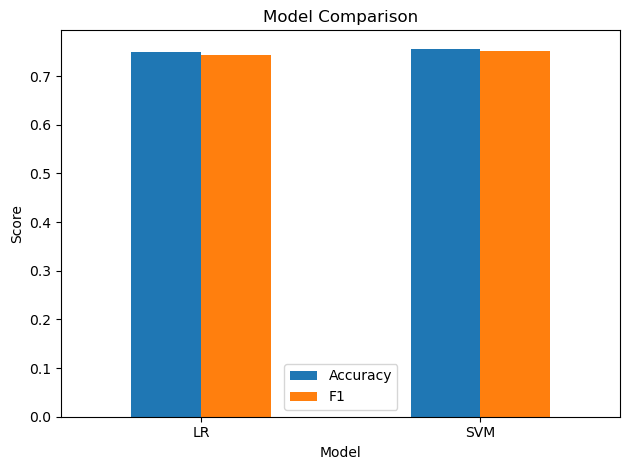


Best model by F1: SVM
F1 score: 0.7516784258562241


In [9]:
# Compare models
results = pd.DataFrame({
    'Model': ['LR', 'SVM'],
    'Accuracy': [lr_accuracy, svm_accuracy],
    'F1': [lr_f1, svm_f1]
})

print(results)

# Simple plot
plt.figure(figsize=(8, 5))
results.plot(x='Model', y=['Accuracy', 'F1'], kind='bar')
plt.title('Model Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

# Find best model
best_idx = results['F1'].idxmax()
print("\nBest model by F1:", results.loc[best_idx, 'Model'])
print("F1 score:", results.loc[best_idx, 'F1'])

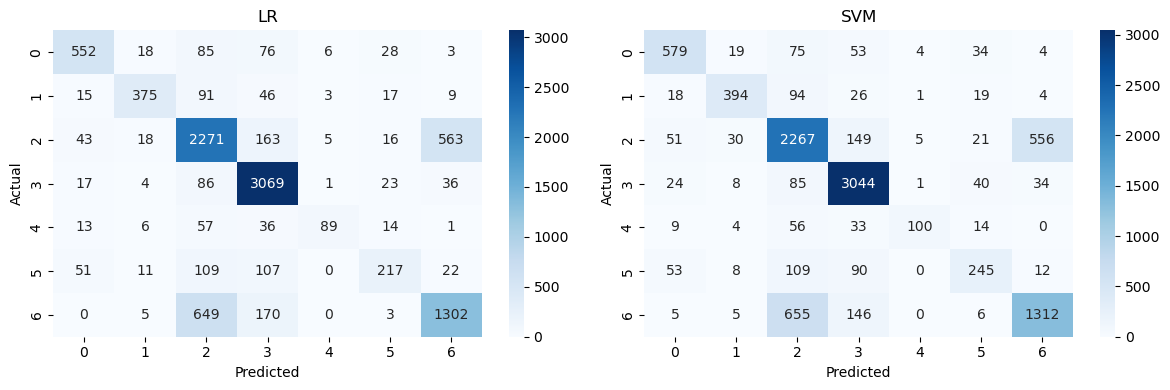


LR:
                      precision    recall  f1-score   support

             Anxiety       0.80      0.72      0.76       768
             Bipolar       0.86      0.67      0.76       556
          Depression       0.68      0.74      0.71      3079
              Normal       0.84      0.95      0.89      3236
Personality disorder       0.86      0.41      0.56       216
              Stress       0.68      0.42      0.52       517
            Suicidal       0.67      0.61      0.64      2129

            accuracy                           0.75     10501
           macro avg       0.77      0.65      0.69     10501
        weighted avg       0.75      0.75      0.74     10501


SVM:
                      precision    recall  f1-score   support

             Anxiety       0.78      0.75      0.77       768
             Bipolar       0.84      0.71      0.77       556
          Depression       0.68      0.74      0.71      3079
              Normal       0.86      0.94      0.90    

In [10]:
# Confusion matrices for LR and SVM
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

predictions = [
    ('LR', y_pred_lr),
    ('SVM', y_pred_svm),
]

labels = [label_mapping[i] for i in range(len(label_mapping))]

for i, (name, pred) in enumerate(predictions):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
    axes[i].set_title(name)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Classification reports
for name, pred in predictions:
    print(f"\n{name}:")
    print(classification_report(y_test, pred, target_names=labels))

In [11]:
# Save models
import os
os.makedirs('models', exist_ok=True)

print("Saving models...")

# Save TF-IDF
joblib.dump(tfidf, 'models/tfidf.pkl')

# Save models
joblib.dump(lr, 'models/lr_model.pkl')
joblib.dump(svm, 'models/svm_model.pkl')

# Save labels
label_dict = {str(k): v for k, v in label_mapping.items()}
with open('models/label_list.json', 'w') as f:
    json.dump(label_dict, f)

print("All models saved!")

Saving models...
All models saved!
